# Cross-validation of models for Scala et al.

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

In [2]:
scala = pickle.load(open('data/scala_2020/scala2020.pickle', 'rb'))
genes=scala['X']
ephys=scala['Y']
gene_names=scala['gene_names']
cell_types=scala['celltypes']
cell_id_to_cell_type=scala['map']
ephys_names=scala['ephys_features']
colors=scala['colors']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [3]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(ephys)

In [4]:
clusters = kmeans.labels_

In [5]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

# Keras initialisations

In [6]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [8]:
# # You should assume you get two TensorFlow variables as input
# y_actual = tf.placeholder(dtype = tf.float32)
# y_predicted = tf.placeholder(dtype = tf.float32)
# def tukey_tf(y_truth, y_pred):
#     c = tf.constant(4.6851, dtype = tf.float32)
#     residual = tf.add(y_truth, -y_pred, name='residual')
#     mask = tf.abs(residual) <= c
#     custom_loss = tf.ones_like(residual, name = 'custom_loss')*((c**2)/6)
#     custom_loss_temp = ((c**2)/6)*(1-(1-(residual/c)**2)**3)
#     custom_loss = tf.where(mask, custom_loss_temp, custom_loss)
#     return tf.reduce_mean(tf.reduce_sum(custom_loss, axis = 1))
#     #return custom_loss
# tukey_tf_result = tukey_tf(y_actual, y_predicted)

In [9]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.placeholder(dtype = tf.float32)
y_predicted = tf.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [10]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Ridge only, test different models w.r.t. reduced-rank-regression

Running all the following models can take up time (~10minutes). One can also simpy load the trained models in the following section. You can jump right into the group losso + ridge setting in the next section.

Our ridge penalty only straight regression (no pre-training) model.

In [28]:
from bottleneck_networks import StraightRegression

In [29]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
MSE_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
MSE_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
train_ephys = []
test_ephys = []
train_ephys_predict = []
test_ephys_predict = []

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]


# CV folds
for cvfold in range(folds):
    print('CVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    train_ephys.append(y_train)
    test_ephys.append(y_test)
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim)
            train_ephys_pred, test_ephys_pred, \
                r2_train, r2_test, train_hist, test_hist, \
                MSE_tr, MSE_test = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0)
            train_ephys_predict.append(train_ephys_pred)
            test_ephys_predict.append(test_ephys_pred)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            MSE_hist[cvfold, j, i] = MSE_test
            MSE_hist_tr[cvfold, j, i] = MSE_tr
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

CVFOLD:  0
[INFO] training network...
Train R^2:  0.4526631236076355
Test R^2:  0.40562015771865845
CVFOLD:  1
[INFO] training network...
Train R^2:  0.5019111633300781
Test R^2:  0.39128899574279785
CVFOLD:  2
[INFO] training network...
Train R^2:  0.43120813369750977
Test R^2:  0.32329273223876953
CVFOLD:  3
[INFO] training network...
Train R^2:  0.42269885540008545
Test R^2:  0.3294333219528198
CVFOLD:  4
[INFO] training network...
Train R^2:  0.46519190073013306
Test R^2:  0.3524671792984009
CVFOLD:  5
[INFO] training network...
Train R^2:  0.42557913064956665
Test R^2:  0.3300928473472595
CVFOLD:  6
[INFO] training network...
Train R^2:  0.49086594581604004
Test R^2:  0.3631784915924072
CVFOLD:  7
[INFO] training network...
Train R^2:  0.4636569619178772
Test R^2:  0.3881339430809021
CVFOLD:  8
[INFO] training network...
Train R^2:  0.4716581106185913
Test R^2:  0.340606153011322
CVFOLD:  9
[INFO] training network...
Train R^2:  0.44509387016296387
Test R^2:  0.3761177062988281
Ti

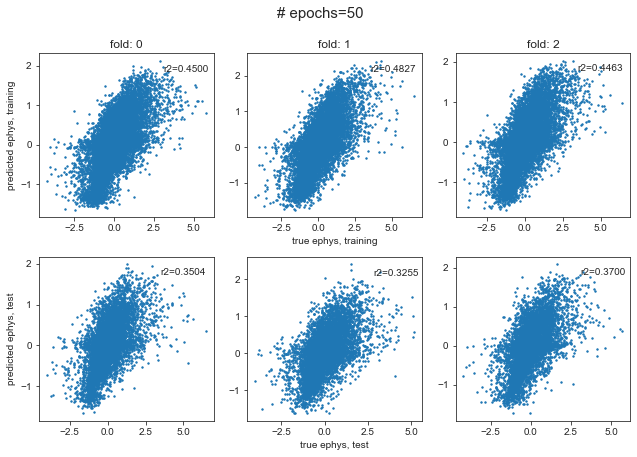

In [261]:
# First visualisation of the data.
fig, axes = plt.subplots(2, folds, figsize=(2*folds, 4))
for i in range(folds):
    axes[0, i].scatter(train_ephys[i], train_ephys_predict[i], s=2)
    axes[0, i].annotate('r2={:.4f}'.format(r2_straight_regr_tr[i, 0, 0]), \
                    xy=(0.5*axes[0, i].get_xlim()[1], 0.8*axes[0, i].get_ylim()[1]))
    axes[0, i].set_title('fold: {}'.format(i))
    axes[1, i].scatter(test_ephys[i], test_ephys_predict[i], s=2)
    axes[1, i].annotate('r2={:.4f}'.format(r2_straight_regr[i, 0, 0]), \
                    xy=(0.5*axes[1, i].get_xlim()[1], 0.8*axes[1, i].get_ylim()[1]))
axes[0, 1].set_xlabel('true ephys, training')
axes[0, 0].set_ylabel('predicted ephys, training')
axes[1, 1].set_xlabel('true ephys, test')
axes[1, 0].set_ylabel('predicted ephys, test')
fig.suptitle('# epochs={}'.format(epochs), fontsize=15, y=1.05)
plt.tight_layout()

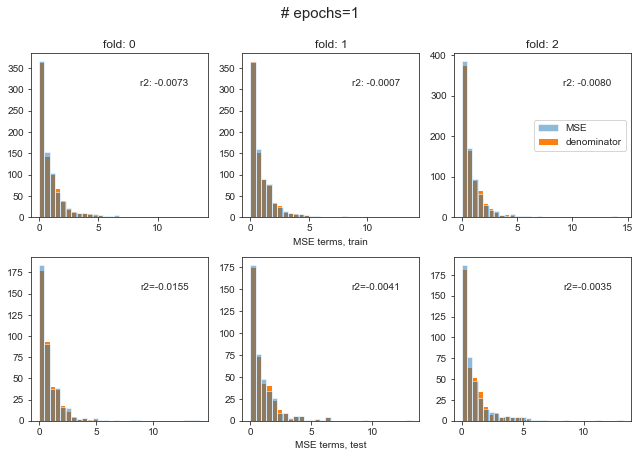

In [228]:
fig, axes = plt.subplots(2, folds, figsize=(2*folds, 4))
for i in range(folds):
    axes[0, i].hist((train_ephys[i]-train_ephys_predict[i])[:, 0]**2, bins=30, alpha=0.5, zorder=1, label='MSE')
    axes[0, i].hist(train_ephys[i][:, 0]**2, bins=30, zorder=0, label='denominator')
    axes[0, i].annotate('r2: {:.4f}'.format(r2_straight_regr_tr[i, 0, 0]), \
                        xy=(0.6*axes[0, i].get_xlim()[1], 0.8*axes[0, i].get_ylim()[1]))
    axes[0, i].set_title('fold: {}'.format(i))
    axes[1, i].hist((test_ephys[i]-test_ephys_predict[i])[:, 0]**2, bins=30, alpha=0.5, zorder=1, label='MSE')
    axes[1, i].hist(test_ephys[i][:, 0]**2, bins=30, zorder=0, label='denominator')
    axes[1, i].annotate('r2={:.4f}'.format(r2_straight_regr[i, 0, 0]), \
                        xy=(0.6*axes[1, i].get_xlim()[1], 0.8*axes[1, i].get_ylim()[1]))
fig.suptitle('# epochs={}'.format(epochs), fontsize=15, y=1.05)
axes[0, 2].legend(loc='right')
axes[0, 1].set_xlabel('MSE terms, train')
axes[1, 1].set_xlabel('MSE terms, test')
plt.tight_layout()

In [30]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_straight_regr.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Our ridge penalty only classification pre-training model.

In [32]:
from bottleneck_networks import ClassificationPreTrain

In [33]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act='elu'
folds=10
seed=42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be done with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
437/437 [==============================] - 0s 103us/sample - loss: 1.9881 - categorical_crossentropy: 1.9881

CVFOLD:  1
[INFO] training network...
437/437 [==============================] - 0s 105us/sample - loss: 2.1318 - categorical_crossentropy: 2.1318

CVFOLD:  2
[INFO] training network...
437/437 [==============================] - 0s 81us/sample - loss: 1.9304 - categorical_crossentropy: 1.9304

CVFOLD:  3
[INFO] training network...
437/437 [==============================] - 0s 103us/sample - loss: 1.9333 - categorical_crossentropy: 1.9333

CVFOLD:  4
[INFO] training network...
437/437 [==============================] - 0s 106us/sample - loss: 2.2000 - categorical_crossentropy: 2.2000

CVFOLD:  5
[INFO] training network...
437/437 [==============================] - 0s 101us/sample - loss: 1.9678 - categorical_crossentropy: 1.9678

CVFOLD:  6
[INFO] training network...
437/437 [==============================] - 0s 135us/sample - loss: 2.1704 

In [34]:
with open('KerasSavedModels/scala_2020/Bottleneck_pre_tr.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Our ridge penalty only pre-train and regression model.

In [35]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5)
            _, _, r2_train, r2_test, train_hist, test_hist, _, _ = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
Train R^2:  0.4711594581604004
Test R^2:  0.4040963649749756

CVFOLD:  1
[INFO] training network...
Train R^2:  0.5154673159122467
Test R^2:  0.4048902988433838

CVFOLD:  2
[INFO] training network...
Train R^2:  0.4908905625343323
Test R^2:  0.37497538328170776

CVFOLD:  3
[INFO] training network...
Train R^2:  0.45307958126068115
Test R^2:  0.3825858235359192

CVFOLD:  4
[INFO] training network...
Train R^2:  0.5788673758506775
Test R^2:  0.38342541456222534

CVFOLD:  5
[INFO] training network...
Train R^2:  0.487598717212677
Test R^2:  0.37408924102783203

CVFOLD:  6
[INFO] training network...
Train R^2:  0.4824718236923218
Test R^2:  0.3439205288887024

CVFOLD:  7
[INFO] training network...
Train R^2:  0.5839717090129852
Test R^2:  0.4261111617088318

CVFOLD:  8
[INFO] training network...
Train R^2:  0.4924424886703491
Test R^2:  0.3871426582336426

CVFOLD:  9
[INFO] training network...
Train R^2:  0.5002471506595612
Test R^2:  0.36731803417205

In [36]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_straight_regr.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Our ridge penalty only pre-train + freeze the first 2 layers + unfreeze model.

In [38]:
from bottleneck_networks import FreezeUnfreeze

In [39]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first


r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 2*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 2*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.396157443523407
Test R^2 before unfreezing:  0.4075890779495239
Train R^2 after unfreezing:  0.48377519845962524
Test R^2 after unfreezing:  0.4336063265800476

CVFOLD:  1
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.4176151752471924
Test R^2 before unfreezing:  0.37342172861099243
Train R^2 after unfreezing:  0.5010496973991394
Test R^2 after unfreezing:  0.39512091875076294

CVFOLD:  2
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.4087764620780945
Test R^2 before unfreezing:  0.3611149191856384
Train R^2 after unfreezing:  0.5160910487174988
Test R^2 after unfreezing:  0.38427281379699707

CVFOLD:  3
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.42144864797592163
Test R^2 before unfreezing:  0.4177473187446594
Train R^2 after unfreezing:  0.4992491602897644
Test R^2 af

In [40]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [41]:
# CV sRRR rank = 2

lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,8)])
alphas = np.array([0])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))

# Uncomment if one lambda only
train_ephys = []
test_ephys = []
train_ephys_predict = []
test_ephys_predict = []

t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    train_ephys.append(y_train)
    test_ephys.append(y_test)
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            
            train_ephys_predict.append(x_train@vx@vy.T)
            test_ephys_predict.append(x_test@vx@vy.T)
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  5m 10s


In [42]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank2_CV.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [43]:
# CV sRRR full rank

lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,8)])
alphas = np.array([0])

rank = ephys.shape[1]
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16_tr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  5m 22s


In [44]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank16_CV.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

We now have cross validated results for all the ridge penalty models we care about. Let us now analyse and compare the training curves. 

In [45]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])

In [46]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank2_CV.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [47]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank16_CV.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [48]:
with open('KerasSavedModels/scala_2020/Bottleneck_pre_tr.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [49]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_straight_regr.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [50]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_straight_regr.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [51]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

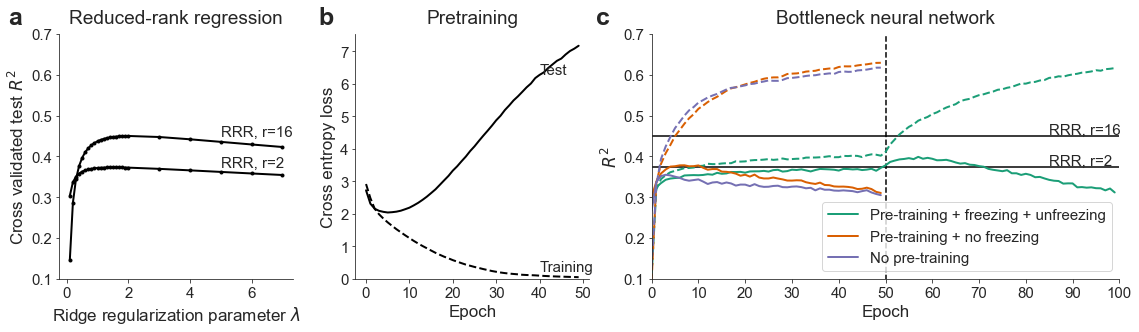

In [58]:
linewidth = 2
sns_styleset()

r2_sRRR_relaxed_rank2[r2_sRRR_relaxed_rank2==0]=np.nan
r2_sRRR_relaxed_rank2_ =  np.nanmean(r2_sRRR_relaxed_rank2, axis = 0)
r2_sRRR_relaxed_rank16[r2_sRRR_relaxed_rank16==0]=np.nan
r2_sRRR_relaxed_rank16_ =  np.nanmean(r2_sRRR_relaxed_rank16, axis = 0)


# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], \
             r2_sRRR_relaxed_rank16_[0, :][np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], '.-', \
             c = np.array([0, 0, 0]) / 256, linewidth = linewidth, \
             label = 'r=16')
ax1.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], \
             r2_sRRR_relaxed_rank2_[0, :][np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], '.-', \
             c = np.array([0, 0, 0])/256, linewidth = linewidth, \
             label = 'r=2')
ax1.annotate('RRR, r=16', (5, np.max(r2_sRRR_relaxed_rank16_)+0.0002), fontsize=15)
ax1.annotate('RRR, r=2', (5, np.max(r2_sRRR_relaxed_rank2_)+0.0002), fontsize=15)
ax1.set_xlabel(r'Ridge regularization parameter $\lambda$', fontsize = 17)
ax1.set_ylabel(r'Cross validated test $R^2$', fontsize = 17)
ax1.set_title('Reduced-rank regression', fontsize = 19, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.set_ylim([0.1,0.7])

ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 1, 2)), \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 1, 2)), \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (40, 0.22), fontsize=15)
ax2.annotate('Test', (40, 6.3), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(100), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(100), np.mean(r2_freeze_unfreeze_hist, axis=(0, 1, 2)), \
         c = '#1b9e77', linewidth=linewidth, label='Pre-training + freezing + unfreezing')
ax3.plot(range(50), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(50), np.mean(r2_pretr_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(50), np.mean(r2_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#7570b3', linewidth=linewidth)
ax3.plot(range(50), np.mean(r2_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#7570b3', linewidth=linewidth, label='No pre-training')
ax3.hlines(np.max(r2_sRRR_relaxed_rank2_), xmin = 0, xmax = 120, \
            colors = np.array([0,0,0])/256)
ax3.annotate('RRR, r=2', (85, np.max(r2_sRRR_relaxed_rank2_)+0.005), fontsize=15)
ax3.hlines(np.max(r2_sRRR_relaxed_rank16_), xmin = 0, xmax = 120, \
           colors = np.array([0,0,0])/256)
ax3.annotate('RRR, r=16', (85, np.max(r2_sRRR_relaxed_rank16_)+0.005), fontsize=15)
ax3.legend(loc = 'lower right', fontsize=15)
ax3.set_ylim([0.1,0.7])
ax3.set_xlim([0,100])
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.set_xticks(np.arange(0, 110, 10))
ax3.vlines(50, ymin=0, ymax=ax3.get_ylim()[1], linestyle='dashed')

plt.text(-0.22, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.16, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.12, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()
plt.savefig('figures/Ridge_training_curves.pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('figures/Ridge_training_curves.png', bbox_inches = 'tight',
    pad_inches = 0)

# Add lasso

It seems that pre-train - train 4 last layers - train all layers is a good bottleneck non-linear model. Let us add a lasso group penalty now and investigate which genes the model would select. After the usual training as above we also prune the bottleneck further. In essence we pick the 25 genes that correspond to highest L2 row norm for the first kernel/weight of the input layer and perform the same regression task but with this reduced new 25 nodes input layer. No lasso, just ridge for this pruned network. We investigate which genes are selected, visualise the latent space and compare to a well-known sparse reduced-rank model for this dataset. Again, one can skip the training and go direct to visualization for already trained models.

Our ridge + lasso penalty straight regression (no pre-training) model.

In [12]:
from bottleneck_networks import StraightRegression

In [13]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[INFO] training network...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The 25 genes that make it:  ['Mical2' 'Rit2' 'Gm43670' 'Plch2' 'Gabra1' 'Elfn1' 'Pde1a' 'Gabrd' 'Grm7'
 'Kcnip2' 'Mybpc1' 'Enpp2' 'Slc6a1' 'Gm49948' 'Atp1a3' 'Lamp5' 'Cplx1'
 'Galnt14' 'Ndn' 'Htr3a' 'Erbb4' 'Tac2' 'Sst' 'Gad1' 'Pvalb']
[INFO] training network...
Train R^2 before pruning:  0.41190963983535767
Test R^2 after pruning:  0.4148900508880615
Train R^2 after pruning:  0.4056796431541443
Test R^2 after pruning:  0.4162428379058838

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Mybpc1' 'Kcnc2' 'Ptk2b' 'Pde1a' 'Kcnip2' 'Nrip3' 'Cplx1' 'Galnt14'
 'Enpp2' 'Elfn1' 'Cck' 'Cdc42se2' 'Gm43670' 'Slc6a1' 'Htr3a' 'Ndn

In [14]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Our ridge + lasso penalty classification pre-training model.

In [15]:
from bottleneck_networks import ClassificationPreTrain

In [16]:
# Immediately for different penalties, but we'll be only interested in the 1e-1 penalty (for now), i.e. see extensions later
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
437/437 [==============================] - 0s 106us/sample - loss: 2.1319 - categorical_crossentropy: 2.0495
[INFO] training network...
437/437 [==============================] - 0s 95us/sample - loss: 9.3589 - categorical_crossentropy: 2.1033
[INFO] training network...
437/437 [==============================] - 0s 82us/sample - loss: 55.2762 - categorical_crossentropy: 2.1206
[INFO] training network...
437/437 [==============================] - 0s 84us/sample - loss: 140.7692 - categorical_crossentropy: 1.9527

CVFOLD:  1
[INFO] training network...
437/437 [==============================] - 0s 76us/sample - loss: 2.0158 - categorical_crossentropy: 1.9334
[INFO] training network...
437/437 [==============================] - 0s 80us/sample - loss: 8.9860 - categorical_crossentropy: 1.9780
[INFO] training network...
437/437 [==============================] - 0s 80us/sample - loss: 51.9812 - categorical_crossentropy: 2.0438
[INFO] training network...

[INFO] training network...
437/437 [==============================] - 0s 81us/sample - loss: 9.4674 - categorical_crossentropy: 2.1991
[INFO] training network...
437/437 [==============================] - 0s 74us/sample - loss: 48.3166 - categorical_crossentropy: 2.0030
[INFO] training network...
437/437 [==============================] - 0s 77us/sample - loss: 197.2893 - categorical_crossentropy: 2.0165

CVFOLD:  9
[INFO] training network...
437/437 [==============================] - 0s 67us/sample - loss: 2.0692 - categorical_crossentropy: 1.9868
[INFO] training network...
437/437 [==============================] - 0s 71us/sample - loss: 9.1333 - categorical_crossentropy: 1.9660
[INFO] training network...
437/437 [==============================] - 0s 74us/sample - loss: 52.2498 - categorical_crossentropy: 2.1679
[INFO] training network...
437/437 [==============================] - 0s 74us/sample - loss: 87.6976 - categorical_crossentropy: 1.9323
Time: 0.0h  7m 21s


In [17]:
with open('KerasSavedModels/scala_2020/Bottleneck_pre_tr_lasso.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Our lasso + ridge penalty pre-train and regression model.

In [18]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['Nell2' 'Gabrd' 'Plch2' 'Gm11549' 'Brinp1' 'Elfn1' 'Unc13c' 'Grm7'
 'Atp1a3' 'Ndst3' 'Chat' 'Htr3a' 'Enpp2' 'Col24a1' 'Cplx1' 'Kcnip2'
 'Galnt14' 'Gm49948' 'Ndn' 'Vip' 'Lamp5' 'Tac2' 'Gad1' 'Pvalb' 'Sst']
[INFO] training network...
Train R^2 before pruning:  0.44383925199508667
Test R^2 after pruning:  0.4500061273574829
Train R^2 after pruning:  0.4239327311515808
Test R^2 after pruning:  0.44444048404693604

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Gm11549' 'Pfkp' 'Gria3' 'Col24a1' 'Ndst3' 'Cck' 'Kcnc2' 'Unc13c' 'Chl1'
 'Grm7' 'Kcnip2' 'Enpp2' 'Htr3a' 'Galnt14' 'Chat' 'Plch2' 'Ndn' 'Atp1a3'
 'Gm49948' 'Lamp5' 'Tac2' 'Vip' 'Gad1' 'Pvalb' 'Sst']
[INFO] training network...
Train R^2 before pruning:  0.43887174129486084
Test R^2 after pruning:  0.4230118989944458
Train R^2 after pruning:  0.4286072254180908
Test R^2 after pruning:  0.41456204652786255

CVFOLD:  2
[INFO] training network...
The 

In [19]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Our lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [20]:
from bottleneck_networks import FreezeUnfreeze

In [21]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0,
                                                                    report_individual_ephys_feature_test_R2=True)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Kcnab1' 'Htr3a' 'App' 'Acsbg1' 'Arrdc3' 'Zfp873' 'Nxph1' 'Hapln4'
 'Slc6a1' 'Npnt' 'Olfm3' 'Lgals9' 'Gad1' 'Ndst3' 'Coro6' 'Rspo2' 'Syt5'
 'Cplx3' 'Calb1' 'Pfkm' 'Rprm' 'Npy2r' 'Kcnip3' 'Scube1' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.4649553894996643
Test R^2 before unfreezing:  0.36090344190597534
Train R^2 after unfreezing:  0.5334055423736572
Test R^2 after unfreezing:  0.37367987632751465
Train R^2 after unfreezing and pruning:  0.4075012803077698
Test R^2 after unfreezing and pruning:  0.40131956338882446
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Dbpht2' 'Npy1r' 'Crym' 'Cplx3' 'Cldn12' 'Flna' 'Slc6a1' 'Ptk2b' 'Sema5a'
 'Mas1' 'Lamp5' 'Rab3b' 'Gm11549' 'Rasgef1b' 'Adcyap1' 'Fezf2' 'Reln'
 'Kcnip1' 'Gad1' 'Stxbp2' 'Thsd7a' 'Kit' 'Tnnt1' 'Sst' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.394257307

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Fez1' 'Enpp2' 'Elmo1' 'Baiap3' 'Pde1a' 'Gad2' 'Npnt' 'Slc6a1' 'Dynlt3'
 'Bcl2l11' 'Neurod6' 'Ptgs2' 'Dpp10' 'Gas7' 'Ndn' 'Rtn3' 'Cplx1' 'Atp1a3'
 'Scube1' 'Pamr1' 'Pvalb' 'Gad1' 'Npas1' 'Erbb4' 'Sst']
[INFO] training network...
Train R^2 before unfreezing:  0.42773932218551636
Test R^2 before unfreezing:  0.2978932857513428
Train R^2 after unfreezing:  0.5019218921661377
Test R^2 after unfreezing:  0.33702075481414795
Train R^2 after unfreezing and pruning:  0.3942604660987854
Test R^2 after unfreezing and pruning:  0.37302446365356445
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Enpp2' 'Sema3c' 'Atp1a3' 'Plch2' 'Kcnip2' 'Gabrd' 'Phactr1' 'Elfn1'
 'Pcp4l1' 'Erbb4' 'Afap1' 'Tac2' 'Ndst3' 'Cacna1e' 'Cplx1' 'Htr3a'
 'Galnt14' 'Sparcl1' 'Gm49948' 'Ndn' 'Sst' 'Gad1' 'Lamp5' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.3797985911369324
Test R

[INFO] training network...
The 25 genes that make it:  ['Ndst3' 'Afap1' 'Kcnc2' 'Slc6a1' 'Plch2' 'Crh' 'Nell1' 'Gm11549' 'Enpp2'
 'Kcnip2' 'Elmo1' 'Elfn1' 'Erbb4' 'Unc13c' 'Htr3a' 'Sparcl1' 'Gabrd'
 'Tac2' 'Gm49948' 'Gad1' 'Ndn' 'Lamp5' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4014137387275696
Test R^2 before unfreezing:  0.368444561958313
Train R^2 after unfreezing:  0.4315599203109741
Test R^2 after unfreezing:  0.4137566089630127
Train R^2 after unfreezing and pruning:  0.43201327323913574
Test R^2 after unfreezing and pruning:  0.4133281707763672
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Cbln2' 'Gaa' 'Bdnf' 'Elfn1' 'Cacna2d3' 'Zfp11' 'Satb1' 'Adamts15'
 'Col24a1' 'Cacna2d1' 'Mlip' 'Tac2' 'Kcnab1' 'Nrip3' 'Ak5' 'Ndn' 'Lingo2'
 'Atp1a3' 'Erbb4' 'Ptgs2' 'Ptk2b' 'Lamp5' 'Gad1' 'Tac1' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.3341865539550781
Test R^2 before unfreezing:  0.32475459

[INFO] training network...
The 25 genes that make it:  ['Rab20' 'Fibcd1' 'Gas7' 'Rtn3' 'Vip' 'Galnt14' 'Ndst3' 'Kcnab1' 'Thbs2'
 'Arpp21' 'Slc17a7' 'Cacna2d1' 'Kcnc2' 'Kcnab3' 'Ptk2b' 'Nell2' 'Gm49948'
 'Cbln2' 'Mybpc1' 'Elfn1' 'Synpr' 'Lamp5' 'Htr3a' 'Gad1' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.32852375507354736
Test R^2 before unfreezing:  0.33122390508651733
Train R^2 after unfreezing:  0.3436734080314636
Test R^2 after unfreezing:  0.35936832427978516
Train R^2 after unfreezing and pruning:  0.4015037417411804
Test R^2 after unfreezing and pruning:  0.3826843500137329
Time: 0.0h 26m 42s


In [51]:
np.load('KerasSavedModels/individual_ephys_feature_test_R2_{}_2_0.npz'\
                                                             .format(0))['R2']

array([0.55420566, 0.33378029, 0.0962472 , 0.05226153, 0.79267734,
       0.5848029 , 0.29453856, 0.57771593, 0.63350242, 0.7407237 ,
       0.38038546, 0.38667727, 0.17281944, 0.4360835 , 0.15931642,
       0.81294642])

In [71]:
# For the revision:
individual_ephys_test_R2_scores=np.zeros((folds,Y.shape[1]))
for i in range(folds):
    individual_ephys_test_R2_scores[i,:]=np.load('KerasSavedModels/individual_ephys_feature_test_R2_{}_2_0.npz'\
                                                             .format(i))['R2']
individual_R2_scores={}
individual_R2_scores_std={}
for i in range(Y.shape[1]):
    individual_R2_scores.update(
        {ephys_names[i]:np.mean(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
    individual_R2_scores_std.update(
        {ephys_names[i]:np.std(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
R2_full=np.mean(r2_freeze_unfreeze_hist[:,2,0,-1],axis=0)
print('R^2 score on all: ', R2_full)
print('\nindividual contributions: ')
individual_R2_scores

R^2 score on all:  0.39243056178092955

individual contributions: 


{'AP amp': 0.49401220977306365,
 'AP amp adapt': 0.357252711057663,
 'AP amp CV': 0.044693398475646975,
 'AP thresh': 0.052051889896392825,
 'AP width': 0.7061364650726318,
 'AHP': 0.593338006734848,
 'AI': 0.3126451253890991,
 'ISI CV': 0.45727930068969724,
 'R_input': 0.5144496262073517,
 'Max AP num': 0.7179328218102455,
 'Tau': 0.3035005569458008,
 'Rebound': 0.35031893849372864,
 'V_rest': 0.16743546724319458,
 'Rheobase': 0.36980104446411133,
 'Sag': 0.18966273069381714,
 'UDR': 0.755383838713169}

In [70]:
print("individual contributions \w their std's")
individual_R2_scores_std

individual contributions \w their std's


{'AP amp': 0.058883872679685235,
 'AP amp adapt': 0.051889676871052184,
 'AP amp CV': 0.04375610194756629,
 'AP thresh': 0.02731344258753038,
 'AP width': 0.0688782269337737,
 'AHP': 0.03439212155588583,
 'AI': 0.05994621976693108,
 'ISI CV': 0.06340384187815042,
 'R_input': 0.06818515294631748,
 'Max AP num': 0.03861067576297391,
 'Tau': 0.07228661284646729,
 'Rebound': 0.07025967350643554,
 'V_rest': 0.05058540192896701,
 'Rheobase': 0.05279723198719562,
 'Sag': 0.062032639656990025,
 'UDR': 0.0528489232202896}

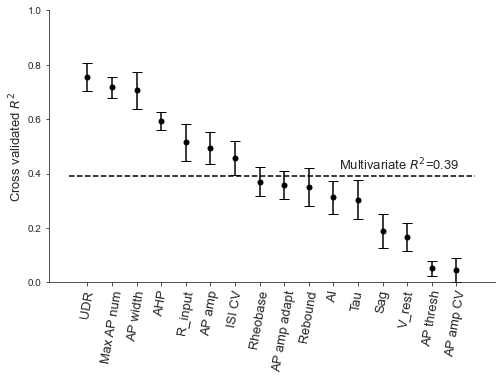

In [66]:
# For the revision
order=np.argsort(np.array([individual_R2_scores[key] for key in individual_R2_scores]))[::-1]
fig, ax = plt.subplots(1,1,figsize=(8,5))
# ax.scatter(
#            np.array([key for key in individual_R2_scores])[order],
#            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
#            color='k'
#           )
ax.errorbar(np.array([key for key in individual_R2_scores])[order],
            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
            np.array([individual_R2_scores_std[key] for key in individual_R2_scores_std])[order],
            marker='.', color='k', markersize=10, capsize=5, linestyle='none')
ax.hlines(R2_full,
          xmin=ax.get_xlim()[0],
          xmax=ax.get_xlim()[1],
          linestyle='dashed')
ax.set_ylim(ymin=0,ymax=1)
ax.annotate(r'Multivariate $R^2$={0:.2f}'.format(R2_full),
           (ax.get_xlim()[0]+1.3*(ax.get_xlim()[1]-ax.get_xlim()[0])/2, R2_full+0.02),
            fontsize=13)
plt.xticks(rotation='80', fontsize=13)
ax.set_ylabel(r'Cross validated $R^2$', fontsize=13)
sns.despine()
plt.savefig('./figures/preliminary/individual_ephys_prediction_scores.png',
            bbox_inches = 'tight',
            pad_inches = 0)
plt.savefig('./figures/preliminary/individual_ephys_prediction_scores.pdf',
            bbox_inches = 'tight',
            pad_inches = 0)

In [24]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [25]:
# CV sRRR rank = 2

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  0m 53s


In [26]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [27]:
# CV sRRR full rank

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = ephys.shape[1]
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  1m 51s


In [28]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

Let us now analyse and visualise the differences.

In [29]:
lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

In [30]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [31]:
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [32]:
with open('KerasSavedModels/scala_2020/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [33]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [34]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [35]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [36]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

In [45]:
print(r_rank16_r[np.isclose(n_rank16, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank16, axis=0)[0, :][np.isclose(n_rank16, 25, atol=3)][0])

0.39811512463141036 +/- 0.016844028073453247


In [46]:
print(r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_rank2, 25, atol=3)][0])

0.35036089702192025 +/- 0.019618703438733235


In [47]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.39243056178092955 +/- 0.030428048376169345


In [48]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.37774274349212644 +/- 0.021511639054706176


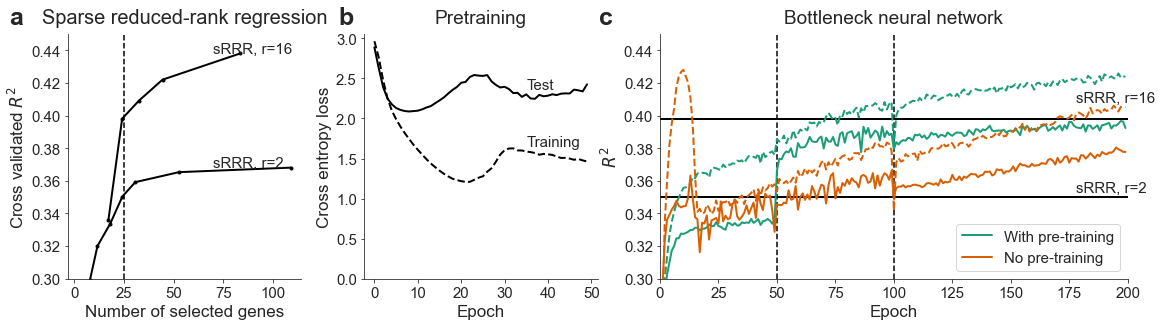

In [49]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.3,0.45])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (70, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Test', (35, 2.36), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
         c = '#1b9e77', linewidth=linewidth, label='With pre-training')
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,0,:], \
#          '--', c = '#d95f02', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,0,:], \
#          c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
         c = '#d95f02', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.3,0.45])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('sRRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.01), fontsize=15)
ax3.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=15)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Lasso_training_curves.png', bbox_inches='tight',
    pad_inches=0)

# Extensions

How many nodes in the bottleneck do we need to really perform clearly above (and relatively soon above) the full rank linear model?

In [81]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks.py'>

In [82]:
from bottleneck_networks import ClassificationPreTrain

In [83]:
# What about using different amount of nodes in the bottleneck?
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], epochs))


for u,f in enumerate(range(2,12,2)):
    nodes_list=[512, 128, f, 128, 512]
    print('Bottleneck with {} nodes'.format(f))
    # CV folds
    for cvfold in range(folds):
        print('\nCVFOLD: ', cvfold)
        indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
        indtrain = np.setdiff1d(np.arange(n), indtest)
        x_train = np.copy(X[indtrain,:])
        clusters_train = np.copy(clusters_[indtrain])
        y_train = np.copy(Y[indtrain,:])
        x_test = np.copy(X[indtest,:])
        clusters_test = np.copy(clusters_[indtest])
        y_test = np.copy(Y[indtest,:])

        # Mean centering (like sRRR)
        X_mean = np.mean(x_train, axis=0)
        x_train -= X_mean
        x_test -= X_mean
        Y_mean = np.mean(y_train, axis=0)
        y_train -= Y_mean
        y_test -= Y_mean

        # In our training set we now look for a 'pretraining' training and test data set that we can use
        # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
        # training set for regression.

        x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
        clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]

        pre_train_size = 0.6
        train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
        x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
        x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
        clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
        clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]

        for i, l2 in enumerate(l2_params):
            #print('Ridge penalty: ', l2)
            for j, l1 in enumerate(l1_params):
                #print('Lasso penalty: ', l1)


                input_dim = x_train.shape[1]
                output_dim = to_categorical(clusters_train_pre_tr).shape[1]
                BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                           output_dim=output_dim, nodes_list=nodes_list)
                CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                                   cluster_train=clusters_train_pre_tr_, \
                                                                                   x_test=x_test_pre_tr_, \
                                                                                   cluster_test=clusters_test_pre_tr_, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0, \
                                                                                   output_name='nodes_list_{}'.format(u))
                CE_loss[u, cvfold, j, i] = CE_test
                CE_loss_tr[u, cvfold, j, i] = CE_train
                pre_tr_hist[u, cvfold, j, i] = test_hist
                pre_tr_hist_tr[u, cvfold, j, i] = train_hist
                #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Bottleneck with 2 nodes

CVFOLD:  0
[INFO] training network...
437/437 [==============================] - 0s 84us/sample - loss: 55.8082 - categorical_crossentropy: 2.1601

CVFOLD:  1
[INFO] training network...
437/437 [==============================] - 0s 83us/sample - loss: 48.6748 - categorical_crossentropy: 2.0537

CVFOLD:  2
[INFO] training network...
437/437 [==============================] - 0s 82us/sample - loss: 48.9267 - categorical_crossentropy: 1.9789

CVFOLD:  3
[INFO] training network...
437/437 [==============================] - 0s 91us/sample - loss: 55.2931 - categorical_crossentropy: 2.1016

CVFOLD:  4
[INFO] training network...
437/437 [==============================] - 0s 87us/sample - loss: 48.2927 - categorical_crossentropy: 2.0351

CVFOLD:  5
[INFO] training network...
437/437 [==============================] - 0s 91us/sample - loss: 55.3030 - categorical_crossentropy: 2.1135

CVFOLD:  6
[INFO] training network...
437/437 [==============================] - 0s 94u

In [84]:
from bottleneck_networks import FreezeUnfreeze

In [86]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

for u,f in enumerate(range(2,12,2)):
    nodes_list=[512, 128, f, 128, 512]
    print('Bottleneck with {} nodes'.format(f))
    # CV folds
    for cvfold in range(folds):
        print('\nCVFOLD: ', cvfold)
        indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
        indtrain = np.setdiff1d(np.arange(n), indtest)
        x_train = np.copy(X[indtrain,:])
        y_train = np.copy(Y[indtrain,:])
        x_test = np.copy(X[indtest,:])
        y_test = np.copy(Y[indtest,:])

        # Mean centering (like sRRR)
        X_mean = np.mean(x_train, axis=0)
        x_train -= X_mean
        x_test -= X_mean
        Y_mean = np.mean(y_train, axis=0)
        y_train -= Y_mean
        y_test -= Y_mean

        input_dim = x_train.shape[1]
        output_dim = y_train.shape[1]

        for i, l2 in enumerate(l2_params):
            #print('Ridge penalty: ', l2)
            for j, l1 in enumerate(l1_params):
                #print('Lasso penalty: ', l1)

                pre_trained_weights_h5 = 'KerasSavedModels/{}/Classification_last_weights_{}_{}_{}.h5'.\
                                                format('nodes_list_{}'.format(u),cvfold, j, i)
                input_dim = x_train.shape[1]
                output_dim = y_train.shape[1]
                BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                           unfreeze = unfreeze, \
                                                           pre_trained_weights=pre_trained_weights, \
                                                           pre_trained_weights_h5=pre_trained_weights_h5, \
                                                           nodes_list=nodes_list)
                r2_before_unfreezing_train, r2_before_unfreezing_test, \
                    r2_after_unfreezing_train, r2_after_unfreezing_test, \
                    r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                    train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                        x_test=x_test, y_test=y_test, \
                                                                        epochs=epochs, bs=bs, patience=patience, \
                                                                        cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                        prune=prune, geneNames=gene_names, \
                                                                        verbose=0)
                r2_before_unfreezing[u, cvfold, j, i] = r2_before_unfreezing_test
                r2_before_unfreezing_tr[u, cvfold, j, i] = r2_before_unfreezing_train
                r2_after_unfreezing[u, cvfold, j, i] = r2_after_unfreezing_test
                r2_after_unfreezing_tr[u, cvfold, j, i] = r2_after_unfreezing_train
                r2_after_unfreezing_ap[u, cvfold, j, i] = r2_after_unfreezing_test_ap
                r2_after_unfreezing_ap_tr[u, cvfold, j, i] = r2_after_unfreezing_train_ap
                r2_freeze_unfreeze_hist[u, cvfold, j, i] = test_hist
                r2_freeze_unfreeze_hist_tr[u, cvfold, j, i] = train_hist
                #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
                #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
                #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Bottleneck with 2 nodes

CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Erbb4' 'Mical2' 'Nell2' 'Phactr1' 'Kcnc2' 'Gabra1' 'Atp1a3' 'Gm11549'
 'Plch2' 'Cplx1' 'Unc13c' 'Gabrd' 'Kcnip2' 'Enpp2' 'Grm7' 'Gm49948'
 'Elfn1' 'Htr3a' 'Galnt14' 'Ndn' 'Lamp5' 'Gad1' 'Tac2' 'Pvalb' 'Sst']
[INFO] training network...
Train R^2 before unfreezing:  0.33830320835113525
Test R^2 before unfreezing:  0.33475446701049805
Train R^2 after unfreezing:  0.4302493929862976
Test R^2 after unfreezing:  0.4383460283279419
Train R^2 after unfreezing and pruning:  0.4181750416755676
Test R^2 after unfreezing and pruning:  0.4496825337409973

CVFOLD:  1
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Slc5a7' 'Nrip3' 'Elfn1' 'Gpm6b' 'Elmo1' 'Cdc42se2' 'Cplx1' 'Pfkp'
 'Grip1' 'Sparcl1' 'Galnt14' 'Col24a1' 'Pcp4l1' 'Enpp2' 'Tac2' 'Plch2'
 'Erbb4' 'Atp1a3' 'Ndn' 'Gm49948' 'Lamp5' 'Gad1' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Tr

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Syt1' 'Plch2' 'Phactr1' 'Sparcl1' 'Cacna1e' 'Gabra1' 'Pdyn' 'Coro6'
 'Elmo1' 'Tafa1' 'Galnt14' 'Ndst3' 'Satb1' 'Tac2' 'Thsd7a' 'Cplx1' 'Fxyd6'
 'Erbb4' 'Ndn' 'Lamp5' 'Htr3a' 'Sst' 'Pvalb' 'Gad1' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4395413398742676
Test R^2 before unfreezing:  0.3468536138534546
Train R^2 after unfreezing:  0.4916002154350281
Test R^2 after unfreezing:  0.44237321615219116
Train R^2 after unfreezing and pruning:  0.4629012942314148
Test R^2 after unfreezing and pruning:  0.436553955078125

CVFOLD:  4
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Gabra1' 'Afap1' 'Fxyd6' 'Tac2' 'Pamr1' 'Plch2' 'Cplx3' 'Coro6' 'Enpp2'
 'Phactr1' 'Tafa1' 'Gm49948' 'Cbln2' 'Lamp5' 'Atp1a3' 'Ndst3' 'Cplx1'
 'Ndn' 'Galnt14' 'Gad1' 'Htr3a' 'Erbb4' 'Sst' 'Vip' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.4619518518447876
Te

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Atp1a3' 'Afap1' 'Gabrd' 'Pcdh7' 'Cdh13' 'Galnt14' 'Pik3r5' 'Tac2'
 'Gm49948' 'Cplx1' 'Cplx3' 'Elmo1' 'Fxyd6' 'Calb1' 'Cbln2' 'Enpp2' 'Htr3a'
 'Ndn' 'Erbb4' 'Ndst3' 'Gad1' 'Lamp5' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.45131832361221313
Test R^2 before unfreezing:  0.36073189973831177
Train R^2 after unfreezing:  0.5129768252372742
Test R^2 after unfreezing:  0.44795727729797363
Train R^2 after unfreezing and pruning:  0.47178345918655396
Test R^2 after unfreezing and pruning:  0.4241349697113037

CVFOLD:  7
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Calb1' 'Mical2' 'Chrnb3' 'Afap1' 'Npy1r' 'Lingo2' 'Sparcl1' 'Atp1a3'
 'Gm49948' 'Phactr1' 'Enpp2' 'Elmo1' 'Ndst3' 'Fxyd6' 'Htr3a' 'Cplx1'
 'Tac2' 'Lamp5' 'Galnt14' 'Erbb4' 'Ndn' 'Gad1' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4524297118186

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Atp1a3' 'Scg2' 'Npy' 'Gabra1' 'Fxyd6' 'Reln' 'Pde1a' 'Satb1' 'Thsd7a'
 'Elmo1' 'Galnt14' 'Cplx1' 'Coro6' 'Pamr1' 'Tac2' 'Plch2' 'Erbb4' 'Ndn'
 'Htr3a' 'Pdyn' 'Lamp5' 'Gad1' 'Pvalb' 'Sst' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.467689573764801
Test R^2 before unfreezing:  0.39991146326065063
Train R^2 after unfreezing:  0.5149269998073578
Test R^2 after unfreezing:  0.44602882862091064
Train R^2 after unfreezing and pruning:  0.4800705909729004
Test R^2 after unfreezing and pruning:  0.4118685722351074
Bottleneck with 10 nodes

CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Pcdh7' 'Gm43670' 'Gm11549' 'Gabra1' 'Cbln2' 'Gm49948' 'Pamr1' 'Elmo1'
 'Ndst3' 'Atp1a3' 'Fxyd6' 'Pdyn' 'Htr3a' 'Enpp2' 'Ndn' 'Thsd7a' 'Erbb4'
 'Galnt14' 'Lamp5' 'Cplx1' 'Tac2' 'Sst' 'Gad1' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0

In [87]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_multiple_nodes.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In [88]:
with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_multiple_nodes.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

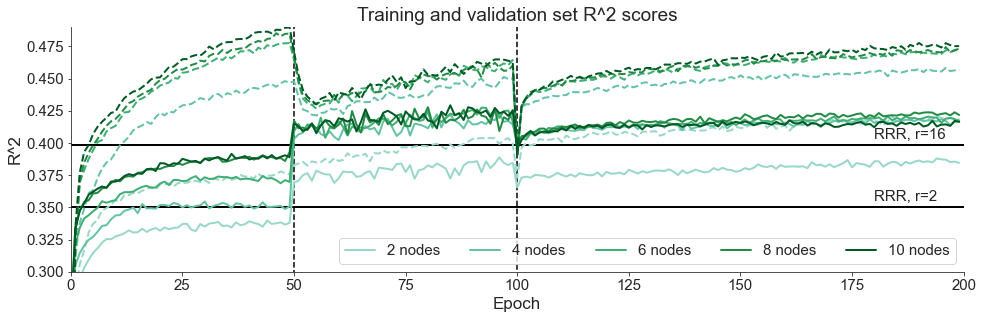

In [89]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

epochs_used = 200
fig = plt.figure(figsize = (16, 4.5))
ax = fig.add_subplot(111)
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for u,f in enumerate(range(2,12,2)):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (1, 2))[u, 0, :], \
             '--', c = colours[u], linewidth=linewidth, label=None)
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (1, 2))[u, 0, :], \
             c = colours[u], linewidth=linewidth, label='{} nodes'.format(f))
ax.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.annotate('RRR, r=16', (180, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.005), fontsize=15)
ax.annotate('RRR, r=2', (180, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.005), fontsize=15)
ax.vlines(x=50, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
ax.vlines(x=100, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
ax.set_ylim([0.3, 0.49])
ax.set_xlim([0, 200])
ax.set_title('Training and validation set R^2 scores', fontsize = 19)
ax.set_xlabel('Epoch', fontsize = 17)
ax.set_ylabel('R^2', fontsize = 17)
ax.legend(loc='lower right', ncol=5, fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
sns.despine()

plt.savefig('figures/Lasso_training_curves_different_nodes.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Lasso_training_curves_different_nodes.png', bbox_inches='tight',
    pad_inches=0)